In [1]:
import pandas as pd
import torch
import torch_geometric as pyg

from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader

from tqdm import tqdm

from sentence_transformers import SentenceTransformer

/opt/homebrew/anaconda3/envs/network_ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(device)

mps


In [3]:
device = "cpu"

## Load data

In [47]:
df_books = pd.read_csv('../data/books.csv')[['book_id', 'title', 'authors']]    # TODO: think about using also the columns
df_ratings = pd.read_csv('../data/ratings.csv')

print(df_books.columns)

Index(['book_id', 'title', 'authors'], dtype='object')


In [48]:
# Create features
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [49]:
# Books features
df_books["text_to_embed"] = "Title: " + df_books["title"] + " Authors: " + df_books["authors"]
with torch.no_grad():
    titles_emb = model.encode(df_books['text_to_embed'].values, device=device, show_progress_bar=True, batch_size=32)
    
del model
torch.cuda.empty_cache()    

books_features = torch.tensor(titles_emb)
print("Books features shape:", books_features.shape)

# Users features: as we don't have any information we will use random features
users_features = torch.rand(df_ratings['user_id'].nunique(), 768, device=device)
print("Users features shape:", users_features.shape)

Batches: 100%|██████████| 313/313 [00:55<00:00,  5.63it/s]


Books features shape: torch.Size([10000, 384])
Users features shape: torch.Size([53424, 768])


In [50]:
# Merge the two dataframes keeping user_id, book_id, rating, title, authors
df_ratings = pd.merge(df_ratings, df_books, on='book_id')
df_ratings.head()

,user_id,book_id,rating,title,authors,text_to_embed
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...,"Carlos Ruiz Zafón, Lucia Graves",Title: The Shadow of the Wind (The Cemetery of...
1,2,4081,4,I am Charlotte Simmons,Tom Wolfe,Title: I am Charlotte Simmons Authors: Tom Wolfe
2,2,260,5,How to Win Friends and Influence People,Dale Carnegie,Title: How to Win Friends and Influence People...
3,2,9296,5,The Drama of the Gifted Child: The Search for ...,"Alice Miller, Ruth Ward",Title: The Drama of the Gifted Child: The Sear...
4,2,2318,3,The Millionaire Next Door: The Surprising Secr...,"Thomas J. Stanley, William D. Danko",Title: The Millionaire Next Door: The Surprisi...
5,2,26,4,"The Da Vinci Code (Robert Langdon, #2)",Dan Brown,"Title: The Da Vinci Code (Robert Langdon, #2) ..."
6,2,315,3,Who Moved My Cheese?,"Spencer Johnson, Kenneth H. Blanchard",Title: Who Moved My Cheese? Authors: Spencer J...
7,2,33,4,Memoirs of a Geisha,Arthur Golden,Title: Memoirs of a Geisha Authors: Arthur Golden
8,2,301,5,Heart of Darkness,Joseph Conrad,Title: Heart of Darkness Authors: Joseph Conrad
9,2,2686,5,Blue Ocean Strategy: How To Create Uncontested...,"W. Chan Kim, Renée Mauborgne",Title: Blue Ocean Strategy: How To Create Unco...


In [8]:
# Create a mapping from the user_id to a unique consecutive value in the range [0, num_users]:
unique_user_id = df_ratings['user_id'].unique()
unique_user_id = pd.DataFrame(data={
    'user_id': unique_user_id, 
    'mapped_user_id': pd.RangeIndex(len(unique_user_id))
    })
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()

# Create a mapping from the book_id to a unique consecutive value in the range [0, num_books]:
unique_book_id = df_ratings['book_id'].unique()
unique_book_id = pd.DataFrame(data={
    'book_id': unique_book_id,
    'mapped_book_id': pd.RangeIndex(len(unique_book_id))
    })
print("Mapping of book IDs to consecutive values:")
print("===========================================")
print(unique_book_id.head())
print()

Mapping of user IDs to consecutive values:
   user_id  mapped_user_id
0        1               0
1        2               1
2        4               2
3        6               3
4        8               4

Mapping of book IDs to consecutive values:
   book_id  mapped_book_id
0      258               0
1     4081               1
2      260               2
3     9296               3
4     2318               4



In [9]:
df_ratings

,user_id,book_id,rating,title,authors,text_to_embed
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...,"Carlos Ruiz Zafón, Lucia Graves",Title: The Shadow of the Wind (The Cemetery of...
1,2,4081,4,I am Charlotte Simmons,Tom Wolfe,Title: I am Charlotte Simmons Authors: Tom Wolfe
2,2,260,5,How to Win Friends and Influence People,Dale Carnegie,Title: How to Win Friends and Influence People...
3,2,9296,5,The Drama of the Gifted Child: The Search for ...,"Alice Miller, Ruth Ward",Title: The Drama of the Gifted Child: The Sear...
4,2,2318,3,The Millionaire Next Door: The Surprising Secr...,"Thomas J. Stanley, William D. Danko",Title: The Millionaire Next Door: The Surprisi...
...,...,...,...,...,...,...
5976474,49925,510,5,"The Great Hunt (Wheel of Time, #2)",Robert Jordan,"Title: The Great Hunt (Wheel of Time, #2) Auth..."
5976475,49925,528,4,"The Dragon Reborn (Wheel of Time, #3)",Robert Jordan,"Title: The Dragon Reborn (Wheel of Time, #3) A..."
5976476,49925,722,4,"The Shadow Rising (Wheel of Time, #4)",Robert Jordan,"Title: The Shadow Rising (Wheel of Time, #4) A..."
5976477,49925,949,5,"The Fires of Heaven (Wheel of Time, #5)",Robert Jordan,"Title: The Fires of Heaven (Wheel of Time, #5)..."


In [10]:
df_ratings = df_ratings.merge(unique_user_id, on='user_id')
df_ratings = df_ratings.merge(unique_book_id, on='book_id')

# With this, we are ready to create the edge_index representation in COO format
# following the PyTorch Geometric semantics:
edge_index = torch.stack([
    torch.tensor(df_ratings['mapped_user_id'].values), 
    torch.tensor(df_ratings['mapped_book_id'].values)]
    , dim=0)

print(edge_index[:, :10])

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])


In [11]:
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData

# Create the heterogeneous graph data object:
data = HeteroData()

# Add the user nodes:
data['user'].x = torch.tensor(users_features,)  # (num_users, num_users_features)

# Add the book nodes:
data['book'].x = torch.tensor(titles_emb,)  # (num_books, num_books_features)

# Add the rating edges:
data['user', 'rates', 'book'].edge_index = edge_index  # (2, num_ratings)

# Add the rating labels:
rating = torch.from_numpy(df_ratings['rating'].values)
data['user', 'rates', 'book'].edge_label = rating  # [num_ratings]

# We also need to make sure to add the reverse edges from books to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

# With the above transformation we also got reversed labels for the edges.
# We remove them
del data['book', 'rev_rates', 'user'].edge_label

assert data['user'].num_nodes == len(unique_user_id)
assert data['user', 'rates', 'book'].num_edges == len(df_ratings)

data

/var/folders/0h/cr6479k54yx2bm781wwm1gwh0000gn/T/ipykernel_7830/1323938127.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data['user'].x = torch.tensor(users_features,)  # (num_users, num_users_features)


HeteroData(
  user={ x=[53424, 768] },
  book={ x=[10000, 384] },
  (user, rates, book)={
    edge_index=[2, 5976479],
    edge_label=[5976479],
  },
  (book, rev_rates, user)={ edge_index=[2, 5976479] }
)

In [20]:
train_data, val_data, test_data = T.RandomLinkSplit(
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'book')],
    rev_edge_types=[('book', 'rev_rates', 'user')],
)(data)
train_data, val_data, test_data

(HeteroData(
   user={ x=[53424, 768] },
   book={ x=[10000, 384] },
   (user, rates, book)={
     edge_index=[2, 4183537],
     edge_label=[4183537],
     edge_label_index=[2, 4183537],
   },
   (book, rev_rates, user)={ edge_index=[2, 4183537] }
 ),
 HeteroData(
   user={ x=[53424, 768] },
   book={ x=[10000, 384] },
   (user, rates, book)={
     edge_index=[2, 4183537],
     edge_label=[597647],
     edge_label_index=[2, 597647],
   },
   (book, rev_rates, user)={ edge_index=[2, 4183537] }
 ),
 HeteroData(
   user={ x=[53424, 768] },
   book={ x=[10000, 384] },
   (user, rates, book)={
     edge_index=[2, 4781184],
     edge_label=[1195295],
     edge_label_index=[2, 1195295],
   },
   (book, rev_rates, user)={ edge_index=[2, 4781184] }
 ))

In [71]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['book'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=10).to(device)
print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (user__rates__book): SAGEConv((-1, -1), 10, aggr=mean)
      (book__rev_rates__user): SAGEConv((-1, -1), 10, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__book): SAGEConv((-1, -1), 10, aggr=mean)
      (book__rev_rates__user): SAGEConv((-1, -1), 10, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=20, out_features=10, bias=True)
    (lin2): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [14]:
# # Define the data loader
# train_dataloader= NeighborLoader(
#     data=train_data,
#     num_neighbors={key: [10] * 2 for key in train_data.edge_types},
#     input_nodes=("user", train_data["user"].x),   # What if we use book?
#     batch_size=32,
# )


In [15]:
# for p in train_dataloader:
#     print(p)
#     break

In [16]:
# # Training Loop
# def train(model, data_loader, optimizer, criterion):
#     model.train()
#     total_loss = 0
#     for batch in data_loader:
#         batch = batch.to(device)
#         optimizer.zero_grad()
#         pred = model(batch.x_dict, batch.edge_index_dict, batch['user', 'rates', 'book'].edge_label_index)
#         print("sium")
#         loss = criterion(pred, batch['user', 'rates', 'book'].edge_label.float())
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * batch.num_graphs
#     return total_loss / len(data_loader.dataset)

# # Testing Loop
# def test(model, data_loader, criterion):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for batch in data_loader:
#             batch = batch.to(device)
#             pred = model(batch.x_dict, batch.edge_index_dict, batch['user', 'rates', 'book'].edge_label_index)
#             loss = criterion(pred, batch['user', 'rates', 'book'].edge_label.float())
#             total_loss += loss.item() * batch.num_graphs
#     return total_loss / len(data_loader.dataset)

# # Main training and testing routines
# optimizer = optim.Adam(model.parameters(), lr=0.01)
# criterion = nn.MSELoss()

# num_epochs = 10
# for epoch in range(num_epochs):
#     train_loss = train(model, train_dataloader, optimizer, criterion)
#     val_loss = test(model, val_data, criterion)
#     print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# # Optionally, after training, you can evaluate your model on the test dataset
# test_loss = test(model, test_data, criterion)
# print(f'Test Loss: {test_loss:.4f}')


In [17]:
# Training Loop
def train(model, data, optimizer, criterion):
    model.train()
    if device != 'cpu':
        data = data.to(device)
    optimizer.zero_grad()
    
    pred = model(data.x_dict, data.edge_index_dict, data['user', 'rates', 'book'].edge_label_index)
    loss = criterion(pred, data['user', 'rates', 'book'].edge_label.float())
    loss.backward()
    optimizer.step()
    total_loss = loss.item()
    return total_loss 

# Testing Loop
def test(model, data, criterion):
    model.eval()
    with torch.no_grad():
        if device != 'cpu':
            data = data.to(device)
        pred = model(data.x_dict, data.edge_index_dict, data['user', 'rates', 'book'].edge_label_index)
        loss = criterion(pred, data['user', 'rates', 'book'].edge_label.float())
        total_loss = loss.item()
    return total_loss

# Main training and testing routines
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

train_losses = []
valid_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_data, optimizer, criterion)
    val_loss = test(model, val_data, criterion)
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    valid_losses.append(val_loss)

# Optionally, after training, you can evaluate your model on the test dataset
test_loss = test(model, test_data, criterion)
print(f'Test Loss: {test_loss:.4f}')

Epoch: 1, Training Loss: 17.2183, Validation Loss: 14.2554
Epoch: 2, Training Loss: 14.2433, Validation Loss: 9.8844
Epoch: 3, Training Loss: 9.8749, Validation Loss: 5.7598
Epoch: 4, Training Loss: 5.7536, Validation Loss: 2.3482
Epoch: 5, Training Loss: 2.3461, Validation Loss: 0.9825
Epoch: 6, Training Loss: 0.9854, Validation Loss: 2.6110
Epoch: 7, Training Loss: 2.6189, Validation Loss: 4.3842
Epoch: 8, Training Loss: 4.3943, Validation Loss: 4.0153
Epoch: 9, Training Loss: 4.0250, Validation Loss: 2.6412
Epoch: 10, Training Loss: 2.6491, Validation Loss: 1.4914
Epoch: 11, Training Loss: 1.4970, Validation Loss: 0.9992
Epoch: 12, Training Loss: 1.0025, Validation Loss: 1.1043
Epoch: 13, Training Loss: 1.1055, Validation Loss: 1.5021
Epoch: 14, Training Loss: 1.5018, Validation Loss: 1.9066
Epoch: 15, Training Loss: 1.9055, Validation Loss: 2.1510
Epoch: 16, Training Loss: 2.1494, Validation Loss: 2.1800
Epoch: 17, Training Loss: 2.1783, Validation Loss: 2.0142
Epoch: 18, Training 

In [20]:
test_loss = test(model, test_data, criterion)

In [21]:
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.9841


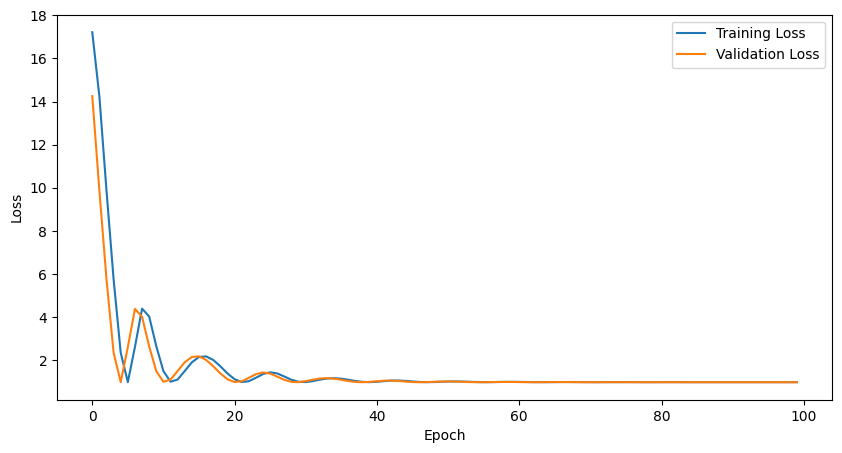

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Save model 
torch.save(model.state_dict(), "model.pt")

## Validation & metrics

In [72]:
model = Model(hidden_channels=10).to(device)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [73]:
pred_review = model(test_data.x_dict, test_data.edge_index_dict, test_data['user', 'rates', 'book'].edge_label_index)

<Axes: >

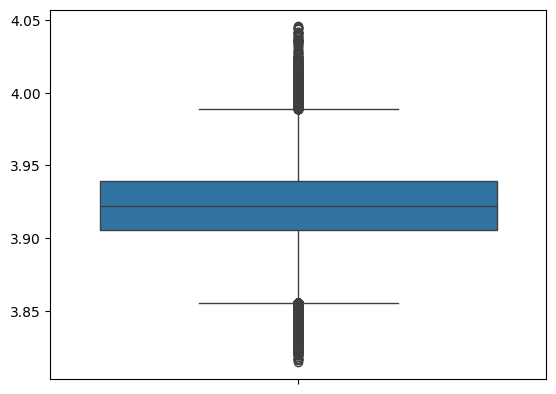

In [88]:
import seaborn as sns
sns.boxplot(pred_review.cpu().detach().numpy())

In [65]:
test_data['user', 'rates', 'book'].edge_label_index

tensor([[40901,  5341,  3808,  ...,  8225, 49572,  3566],
        [ 4893,  8331,  1225,  ...,  5389,  9960,  1551]])

In [68]:
test_data['user', 'rates', 'book'].edge_label

tensor([5, 4, 3,  ..., 5, 4, 4])

In [74]:
# Convert tensors to numpy arrays
user_ids_np = test_data['user', 'rates', 'book'].edge_label_index[0].numpy()
book_ids_np = test_data['user', 'rates', 'book'].edge_label_index[1].numpy()
ratings_np = test_data['user', 'rates', 'book'].edge_label.numpy()
ratings_pred_np = pred_review.detach().numpy()

# Create a dictionary with the data
data = {
    'user_id': user_ids_np,
    'book_id': book_ids_np,
    'rating': ratings_np, 
    'predicted_rating': ratings_pred_np
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

In [82]:
import sys
sys.path.append('../src')
from evaluation_metrics import *

k = 10
top_k_recommendations = get_top_k_recommendations(df, k)
actual_items = get_actual_items(df) # ground truth

# Evaluate the recommendations
mean_precision, mean_recall, mean_f1 = evaluate_recommendations(top_k_recommendations, actual_items, k)
print(f"Mean Precision@{k}: {mean_precision}")
print(f"Mean Recall@{k}: {mean_recall}")
print(f"Mean F1 Score@{k}: {mean_f1}")

Mean Precision@10: 0.7051810471239085
Mean Recall@10: 0.4976877728353774
Mean F1 Score@10: 0.5579174874272494


Matrix factorization:

Mean Precision@10: 0.7722234424908242
Mean Recall@10: 0.5475533441372822
Mean F1 Score@10: 0.6128487333956821

In [ ]:
todo
visualization on how the data looks like


report 
objective and motivation 
analysis of the data
method: improving over matrix factorization baseline
results
future study: even an idea about how to use diversity